# Customer Segmentation

### Reading Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import sklearn.metrics as silhouette_score
import seaborn as sns

customer_metrics = pd.read_csv('../data/processed/customer_metrics_without_outliers.csv')

In [2]:
customer_metrics.head()

,Customer ID,TotalSpent,OrderCount,FirstInvoiceDate,LastInvoiceDate,CustomerLifespan,Recency,PurchaseFrequency
0,12346.0,169.36,2,2010-03-02 13:08:00,2010-06-28 13:53:00,118,164,0.51
1,12347.0,1323.32,2,2010-10-31 14:20:00,2010-12-07 14:57:00,37,2,1.62
2,12348.0,221.16,1,2010-09-27 14:59:00,2010-09-27 14:59:00,1,73,30.00
3,12349.0,2221.14,2,2010-04-29 13:20:00,2010-10-28 08:23:00,181,42,0.33
4,12351.0,300.93,1,2010-11-29 15:23:00,2010-11-29 15:23:00,1,10,30.00


### Scaling Features

In [3]:
segmentation_features = ['TotalSpent', 'PurchaseFrequency', 'Recency']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_metrics[segmentation_features]) # numpy array with standard deviation

scaled_features_df = pd.DataFrame(scaled_features, index=customer_metrics.index, \
                                  columns=('TotalSpent', 'PurchaseFrequency', 'Recency'))


In [4]:
scaled_features

array([[-0.8785598 , -0.80385049,  0.69584071],
       [ 0.48892184, -0.7306533 , -0.96050629],
       [-0.81717504,  1.14082062, -0.23457643],
       ...,
       [-0.63249937,  1.14082062,  2.03523243],
       [ 0.39780459, -0.82165521,  0.15394941],
       [ 1.64123689, -0.79527784, -0.80714083]])

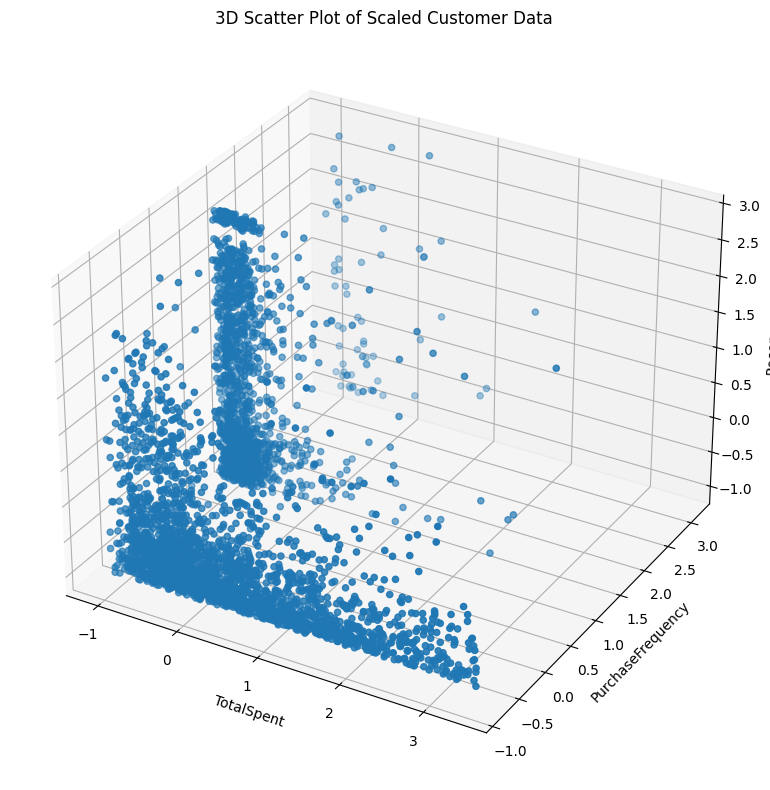

In [5]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection='3d')
ax.scatter(
  scaled_features_df['TotalSpent'],
  scaled_features_df['PurchaseFrequency'],
  scaled_features_df['Recency']
)
ax.set_xlabel('TotalSpent')
ax.set_ylabel('PurchaseFrequency')
ax.set_zlabel('Recency')
ax.set_title('3D Scatter Plot of Scaled Customer Data')

plt.tight_layout()
plt.show()

### Finding out Optimal Clusters

In [6]:
inertias = []
silhouette_scores = [] #-1 - 1 score to determine cluster overlapping (high means less overlap)
k_values = range(2, 11)

for k in k_values:
  kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000, n_init='auto')
  cluster_labels = kmeans.fit_predict(scaled_features_df)
  sil_score = silhouette_score.silhouette_score(scaled_features_df, cluster_labels)
  silhouette_scores.append(sil_score)
  inertias.append(kmeans.inertia_)

scaled_features_df

,TotalSpent,PurchaseFrequency,Recency
0,-0.878560,-0.803850,0.695841
1,0.488922,-0.730653,-0.960506
2,-0.817175,1.140821,-0.234576
3,1.552869,-0.815720,-0.551532
4,-0.722645,1.140821,-0.878711
...,...,...,...
3847,-0.318738,-0.794618,-0.807141
3848,-0.591402,1.140821,-0.306147
3849,-0.632499,1.140821,2.035232
3850,0.397805,-0.821655,0.153949


### Plotting Elbow Curve

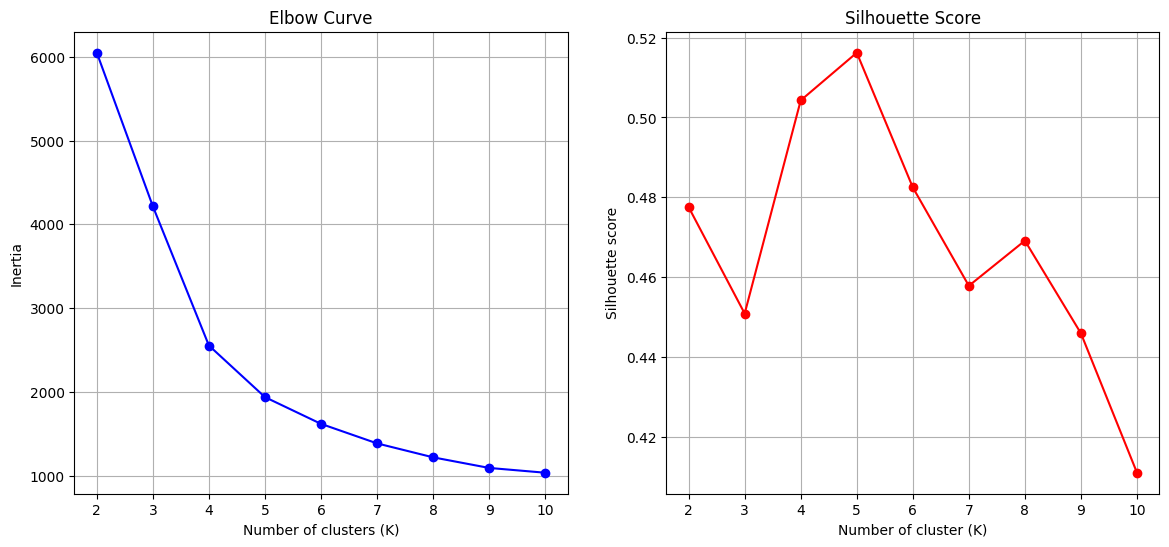

In [7]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertias, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.title('Elbow Curve')

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, 'ro-')
plt.xlabel('Number of cluster (K)')
plt.ylabel('Silhouette score')
plt.grid(True)

plt.title('Silhouette Score')
plt.show()

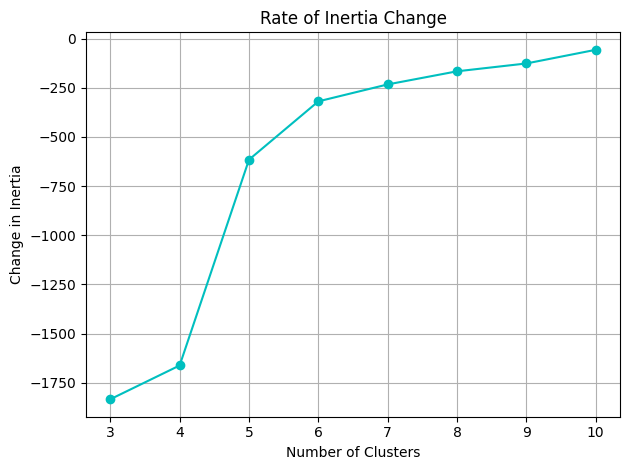

In [10]:
inertia_changes = np.diff(inertias)
plt.plot(k_values[1:], inertia_changes, 'co-')
plt.xlabel('Number of Clusters')
plt.ylabel('Change in Inertia')
plt.title('Rate of Inertia Change')
plt.tight_layout()
plt.grid(True)
plt.show()

### Segmenting Customers

In [11]:
kmeans_4 = KMeans(n_clusters=4, n_init=10, random_state=42)
customer_metrics['Segment'] = kmeans_4.fit_predict(scaled_features)

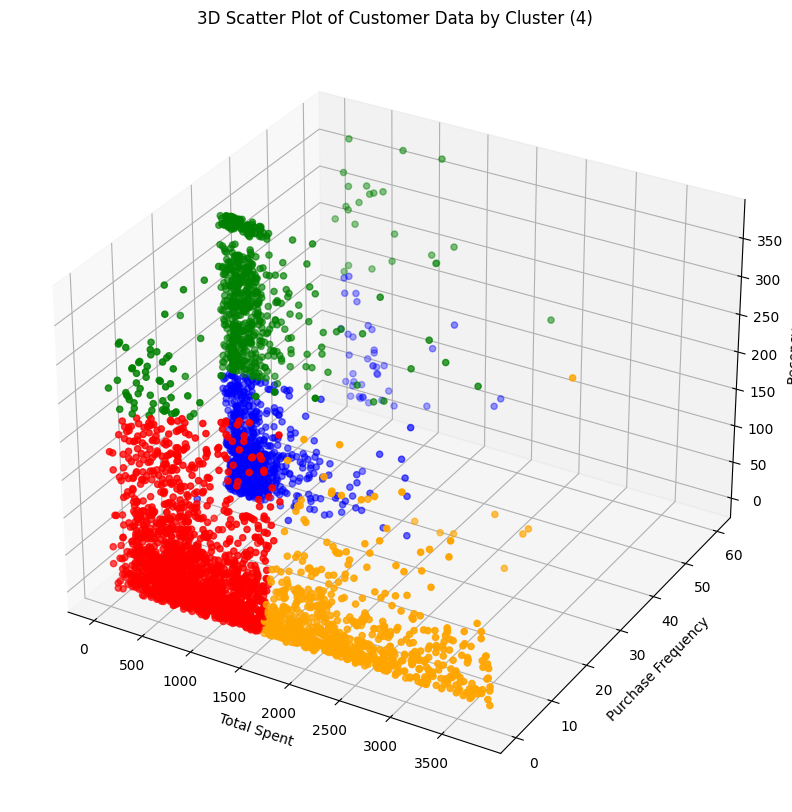

In [12]:
cluster_colors = {
  0: 'blue',
  1: 'orange',
  2: 'green',
  3: 'red'
}

colors = customer_metrics['Segment'].map(cluster_colors)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(customer_metrics['TotalSpent'],
                     customer_metrics['PurchaseFrequency'],
                     customer_metrics['Recency'],
                     c=colors,
                     marker='o')

ax.set_xlabel('Total Spent')
ax.set_ylabel('Purchase Frequency')
ax.set_zlabel('Recency')
ax.set_title('3D Scatter Plot of Customer Data by Cluster (4)')
plt.show()

### Visualizing Segment Spread in RFM 

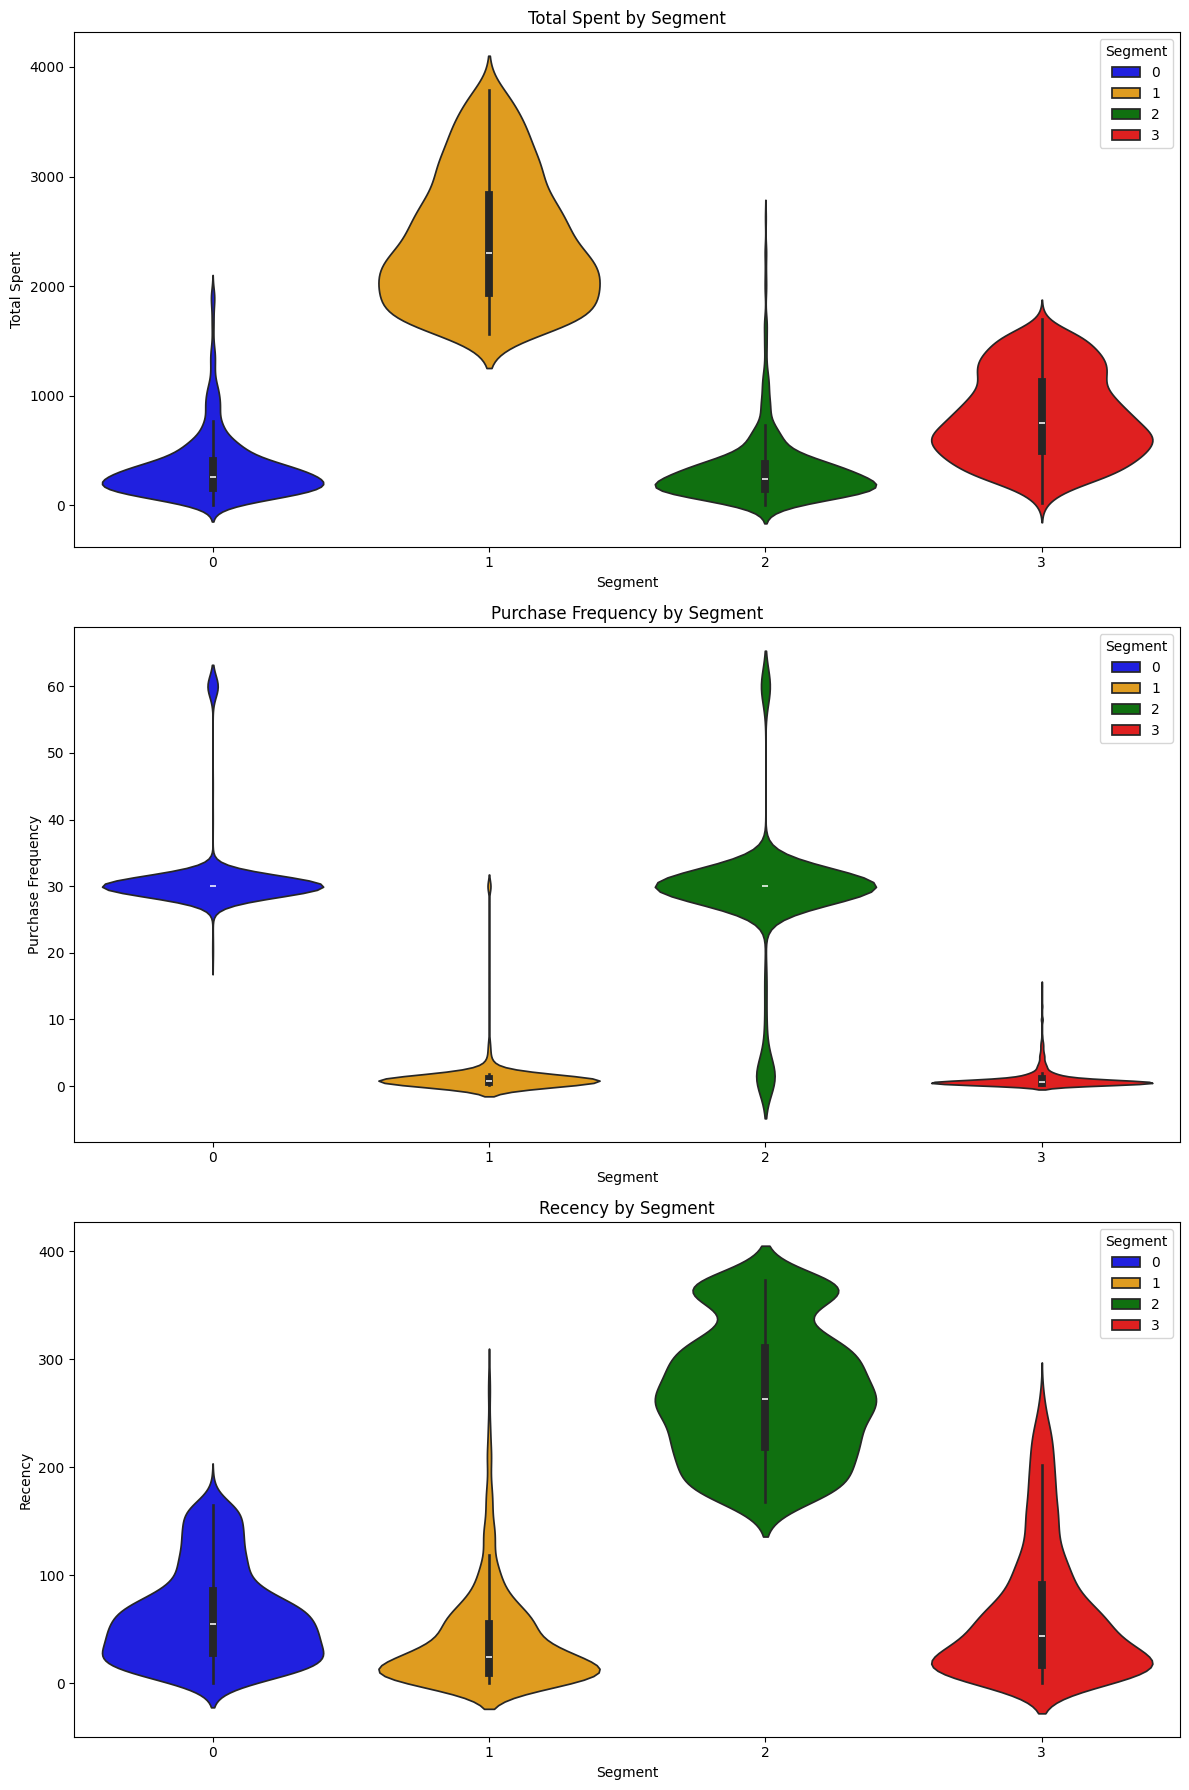

In [13]:
plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x='Segment', y='TotalSpent', data=customer_metrics, palette=cluster_colors, hue='Segment')
plt.title('Total Spent by Segment')
plt.ylabel('Total Spent')

plt.subplot(3, 1, 2)
sns.violinplot(x='Segment', y='PurchaseFrequency', data=customer_metrics, palette=cluster_colors, hue='Segment')
plt.title('Purchase Frequency by Segment')
plt.ylabel('Purchase Frequency')

plt.subplot(3, 1, 3)
sns.violinplot(x='Segment', y='Recency', data=customer_metrics, palette=cluster_colors, hue='Segment')
plt.title('Recency by Segment')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

In [14]:
segment_analysis = customer_metrics.groupby('Segment').agg(
  AvgTotalSpent= ('TotalSpent','mean'),
  TotalSpentCount= ('TotalSpent', 'count'),
  AvgPurchaseFrequency= ('PurchaseFrequency', 'mean'),
  AvgCustomerLifespan= ('CustomerLifespan', 'mean')
).round(2)
segment_analysis

,AvgTotalSpent,TotalSpentCount,AvgPurchaseFrequency,AvgCustomerLifespan
Segment,,,,
0,341.13,846,31.31,1.02
1,2419.46,699,1.32,246.40
2,320.42,693,28.53,5.88
3,809.37,1614,1.08,170.15


### Adding Segment Labels

In [ ]:
def label_segments_category(row):
  if row['AvgTotalSpent'] > 1500 and row['']

In [14]:
def label_segments(row):
  if row['AvgTotalSpent'] > 1800 and row['AvgPurchaseFrequency'] < 3:
    return('HighValueIrregular')
  elif row['AvgTotalSpent'] > 500 and row['AvgPurchaseFrequency'] < 3:
    return('HighSpendingIrregular')
  elif row['AvgPurchaseFrequency'] > 30 and row['AvgCustomerLifespan'] < 3:
    return('BudgetOld')
  elif row['AvgPurchaseFrequency'] < 30 and row['AvgCustomerLifespan'] > 3:
    return('BudgetNew')
  else:
    return('Oulier')

segment_analysis['SegmentLabel'] = segment_analysis.apply(label_segments, axis=1)
segment_analysis

,AvgTotalSpent,TotalSpentCount,AvgPurchaseFrequency,AvgCustomerLifespan,SegmentLabel
Segment,,,,,
0,341.13,846,31.31,1.02,BudgetOld
1,2419.46,699,1.32,246.40,HighValueIrregular
2,320.42,693,28.53,5.88,BudgetNew
3,809.37,1614,1.08,170.15,HighSpendingIrregular


In [15]:
segment_analysis.columns = ['AvgTotalSpent', 'TotalSpentCount', 'AvgPurchaseFrequency', 'AvgCustomerLifespan', 'SegmentLabel']

### Visualizing Segments

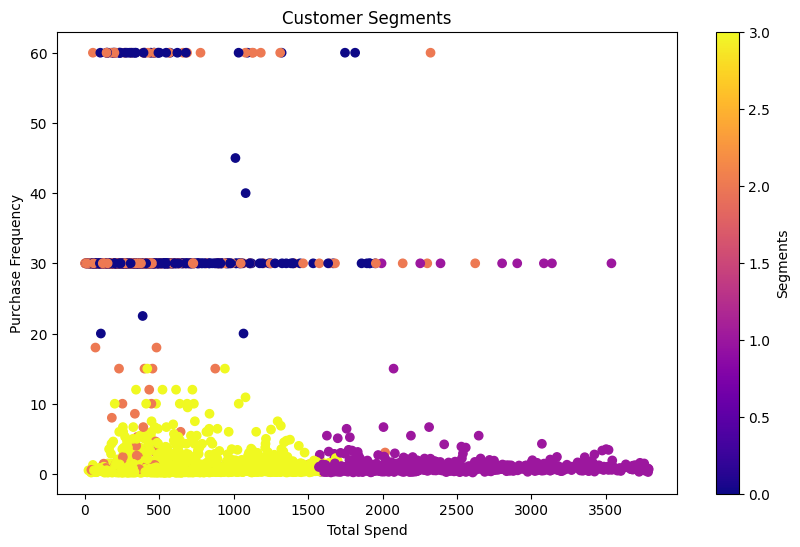

In [16]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(customer_metrics['TotalSpent'],
                      customer_metrics['PurchaseFrequency'],
                      c=customer_metrics['Segment'],
                      cmap='plasma'
                      )
plt.xlabel('Total Spend')
plt.ylabel('Purchase Frequency')
plt.title('Customer Segments')
plt.colorbar(label='Segments')

plt.show()

In [17]:
customer_metrics.head()

,Customer ID,TotalSpent,OrderCount,FirstInvoiceDate,LastInvoiceDate,CustomerLifespan,Recency,PurchaseFrequency,Segment
0,12346.0,169.36,2,2010-03-02 13:08:00,2010-06-28 13:53:00,118,164,0.51,3
1,12347.0,1323.32,2,2010-10-31 14:20:00,2010-12-07 14:57:00,37,2,1.62,3
2,12348.0,221.16,1,2010-09-27 14:59:00,2010-09-27 14:59:00,1,73,30.00,0
3,12349.0,2221.14,2,2010-04-29 13:20:00,2010-10-28 08:23:00,181,42,0.33,1
4,12351.0,300.93,1,2010-11-29 15:23:00,2010-11-29 15:23:00,1,10,30.00,0


In [18]:
segment_label = {
  0: 'BudgetRegular',
  1: 'BudgetIrregular',
  2: 'HighValueIrregular',
  3: 'HighSpendingIrregular'
}
customer_metrics.reset_index()
customer_metrics['SegmentLabel'] = customer_metrics['Segment'].map(segment_label)

### Exporting Data

In [19]:
segment_analysis.to_csv('../data/processed/customer_segments.csv', index=False)
customer_metrics.to_csv('../data/processed/customer_metrics_segments.csv', index=False)